<a href="https://colab.research.google.com/github/gurjinderbassi/CSE676-Project/blob/main/DRdetection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
!pip install tensorflow_addons
import tensorflow_addons as tfa
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.1 MB 9.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip drive/My\ Drive/Data/train_preprocessed.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/03c85870824c.jpg  
  inflating: __MACOSX/train_images/._03c85870824c.jpg  
  inflating: train_images/785777558f05.jpg  
  inflating: __MACOSX/train_images/._785777558f05.jpg  
  inflating: train_images/92e3d608fd3c.jpg  
  inflating: __MACOSX/train_images/._92e3d608fd3c.jpg  
  inflating: train_images/62cc7ddb53b6.jpg  
  inflating: __MACOSX/train_images/._62cc7ddb53b6.jpg  
  inflating: train_images/72595230840c.jpg  
  inflating: __MACOSX/train_images/._72595230840c.jpg  
  inflating: train_images/1f3f32efaf20.jpg  
  inflating: __MACOSX/train_images/._1f3f32efaf20.jpg  
  inflating: train_images/54b322c66d01.jpg  
  inflating: __MACOSX/train_images/._54b322c66d01.jpg  
  inflating: train_images/80b5a9519aec.jpg  
  inflating: __MACOSX/train_images/._80b5a9519aec.jpg  
  inflating: train_images/38fe9f854046.jpg  
  inflating: __MACOSX/train_images/._38fe9f854046.jpg  
  inflating: train_images/a8854768549f.j

In [4]:
import shutil
df = pd.read_csv('train.csv',names=['Filename','Class'])
labels = df.sort_values('Class')
class_names = list(labels.Class.unique())
class_names = class_names[:-1]
for i in class_names:
    os.makedirs('train_'+i)
for c in class_names:
    for i in list(labels[labels['Class']==c]['Filename']):
        get_image = os.path.join('train_images',i)
        if not os.path.exists('train_'+c+i):
            shutil.copy(get_image,'train_'+c)

In [5]:
train = []
label = []
# os.listdir returns the list of files in the folder, in this case image class names
for i in ['train_0','train_1','train_2','train_3','train_4']:
      imgs = os.listdir(i)
      for img_name in imgs:
          img_path = os.path.join(i,img_name)
          train.append(img_path)
          label.append(i.split('_')[1])
retina_df = pd.DataFrame({'Image': train, 'Labels': label})
# retina_df[retina_df['Labels']=='0']
retina_df

,Image,Labels
0,train_0/76f3473df8a6.jpg,0
1,train_0/c9c563864ab1.jpg,0
2,train_0/54038e56131d.jpg,0
3,train_0/27933cdbe0cc.jpg,0
4,train_0/d911dd40c63b.jpg,0
...,...,...
3657,train_4/0e0fc1d9810c.jpg,4
3658,train_4/0981195eb9fb.jpg,4
3659,train_4/a2ddabee14e9.jpg,4
3660,train_4/66375b3c64db.jpg,4


In [6]:
import PIL
# img_path = train.iloc[0,0]
# sample_img = PIL.Image.open(img_path)
# print(sample_img.mode)

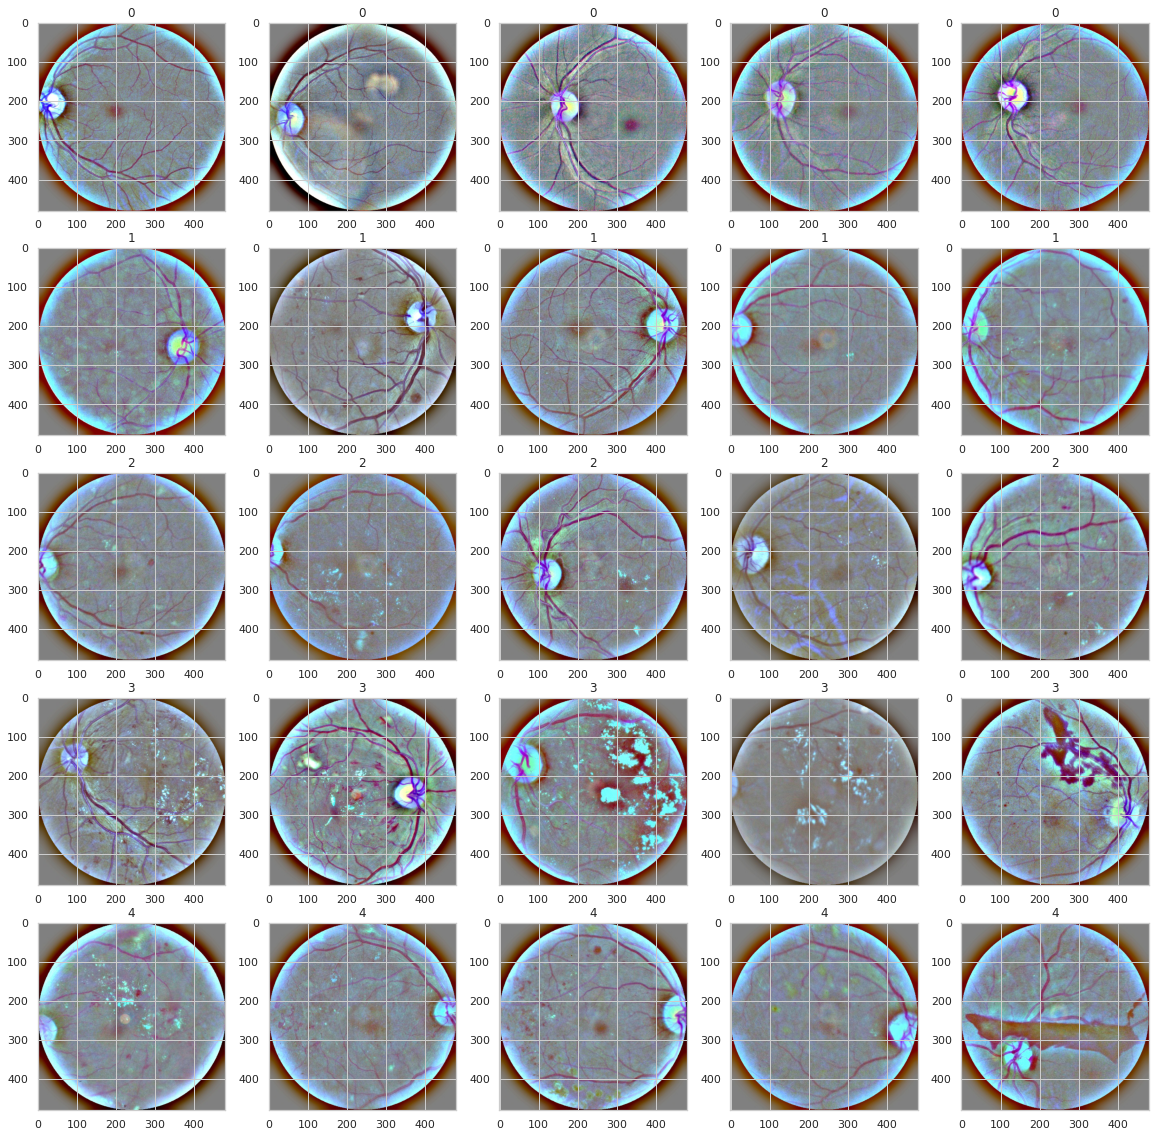

In [7]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in range(5):
  # get the list of images in a given class
  train_class = os.listdir('train_'+ str(i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('train_'+str(i), train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

# fig.tight_layout()

In [9]:
# shuffle the retina_df
from sklearn.utils import shuffle
retina_df = shuffle(retina_df)

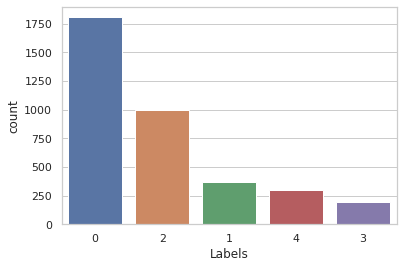

In [10]:
import seaborn as sns
sns.countplot(data = retina_df, x='Labels', order=retina_df['Labels'].value_counts().index)

In [11]:
# train-test split
from sklearn.model_selection import train_test_split
train, test_val = train_test_split(retina_df, test_size=0.3, random_state = 101, shuffle = True)
test, val = train_test_split(test_val, test_size = 0.5, random_state=101, shuffle=True)

In [12]:
test

,Image,Labels
281,train_0/ff4cd992667b.jpg,0
1850,train_1/27e4c800a449.jpg,1
2588,train_2/f0800723bc63.jpg,2
1422,train_0/e8e44b3160e3.jpg,0
950,train_0/d7a01fca9838.jpg,0
...,...,...
1595,train_0/96b5474ae604.jpg,0
1648,train_0/13073f075a56.jpg,0
2505,train_2/43fb6eda9b97.jpg,2
2112,train_1/db690e2d02f8.jpg,1


In [13]:
val

,Image,Labels
363,train_0/e8ddfc9709ce.jpg,0
3027,train_2/f18abfa690ab.jpg,2
3589,train_4/1bf30c84bbad.jpg,4
1852,train_1/3c72f580d4ba.jpg,1
3518,train_4/ba08cee68c71.jpg,4
...,...,...
500,train_0/4a96c28f3f07.jpg,0
1766,train_0/f85fd4fac887.jpg,0
774,train_0/d516f77d4516.jpg,0
2468,train_2/daeaa5d8cf70.jpg,2


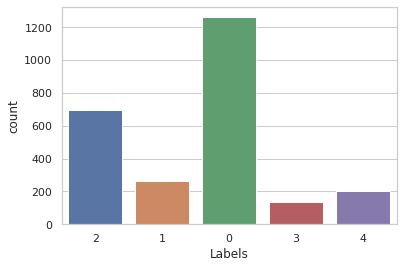

In [14]:
import seaborn as sns
sns.countplot(data = train, x='Labels')

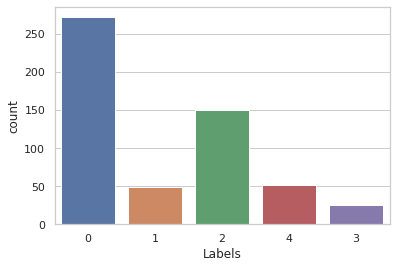

In [15]:
sns.countplot(data = test, x = 'Labels')

In [16]:
image_size = 224
batch_size = 32
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from skimage import exposure
import matplotlib.pyplot as plt
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=360, 
    horizontal_flip=True,
    vertical_flip=True)

dev_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [17]:

train_generator=train_datagen.flow_from_dataframe(
    dataframe = train,
    directory='./',
    batch_size=32,
    x_col = 'Image',
    y_col = 'Labels',
    shuffle = False,
    class_mode='sparse',
    target_size=(image_size, image_size))

valid_generator=dev_datagen.flow_from_dataframe(
    dataframe=val,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))

test_generator=dev_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))


Found 2563 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


## Model 1

In [18]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [19]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(5, activation='softmax')
])

     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [21]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.0001, mode='auto')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
#set up callbacks
checkpoint_path = "Reg01/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
#train model
epochs = 30
steps_per_epoch = train_generator.n // batch_size
dev_steps = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_generator,
                              validation_steps=dev_steps, 
                              callbacks=[cp_callback, early_stop]
                              )

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 1.3611 - sparse_categorical_accuracy: 0.4536 - cohen_kappa: 0.0684
Epoch 1: saving model to Reg01/cp.ckpt
80/80 [==============================] - 45s 385ms/step - loss: 1.3611 - sparse_categorical_accuracy: 0.4536 - cohen_kappa: 0.0684 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.5478 - val_cohen_kappa: 0.2264
Epoch 2/30
79/80 [============================>.] - ETA: 0s - loss: 1.1182 - sparse_categorical_accuracy: 0.5890 - cohen_kappa: 0.2900
Epoch 2: saving model to Reg01/cp.ckpt
80/80 [==============================] - 34s 413ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.5899 - cohen_kappa: 0.2915 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.6195 - val_cohen_kappa: 0.3538
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 1.0137 - sparse_categorical_accuracy: 0.6409 - cohen_kappa: 0.3916
Epoch 3: saving model to Reg01/cp.ckpt
80/80 [==============================] - 3

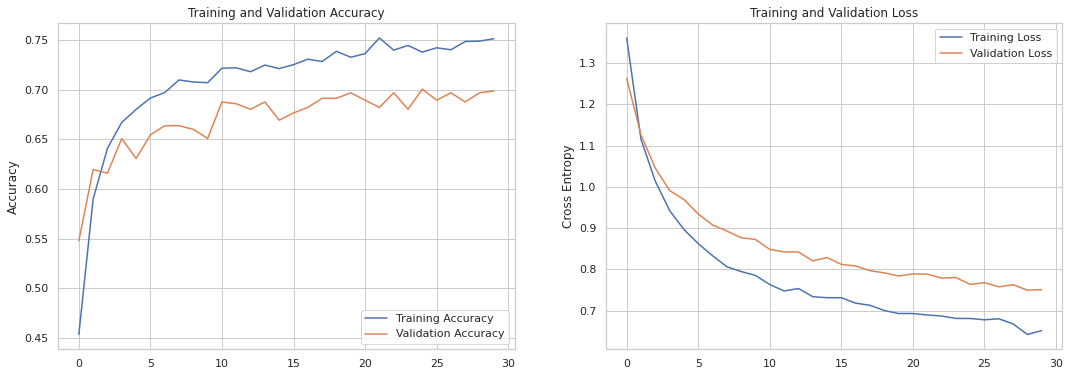

In [49]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Prediction performance on validation dataset

In [25]:
from sklearn.metrics import accuracy_score
predictions = model.predict_generator(valid_generator)
predictions = np.argmax(predictions, axis=-1)
val['Labels'] = val['Labels'].astype(int)
score = accuracy_score(val['Labels'], predictions)
print('Accuracy:',score)

Accuracy: 0.7018181818181818


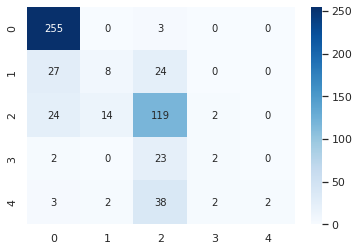

In [26]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(val['Labels'], predictions)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')

In [27]:
from sklearn.metrics import classification_report
print(classification_report(val['Labels'], predictions))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       258
           1       0.33      0.14      0.19        59
           2       0.57      0.75      0.65       159
           3       0.33      0.07      0.12        27
           4       1.00      0.04      0.08        47

    accuracy                           0.70       550
   macro avg       0.61      0.40      0.39       550
weighted avg       0.69      0.70      0.64       550



Prediction performance on test dataset

In [168]:
test['Labels'] = test['Labels'].astype(str)
test_generator=dev_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))

Found 549 validated image filenames belonging to 5 classes.


In [29]:
from sklearn.metrics import accuracy_score
predictions = model.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=-1)
test['Labels'] = test['Labels'].astype(int)
score = accuracy_score(test['Labels'], predictions)
print('Test Accuracy:',score)

Test Accuracy: 0.7285974499089253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

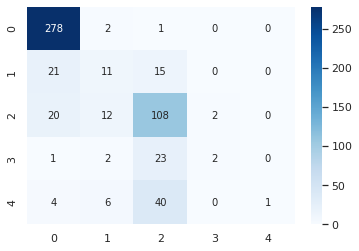

In [45]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(test['Labels'], predictions)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')
from google.colab import files
plt.savefig("cnf1.png")
files.download("cnf1.png") 

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test['Labels'], predictions))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       281
           1       0.33      0.23      0.28        47
           2       0.58      0.76      0.66       142
           3       0.50      0.07      0.12        28
           4       1.00      0.02      0.04        51

    accuracy                           0.73       549
   macro avg       0.65      0.41      0.40       549
weighted avg       0.74      0.73      0.67       549



## Model 2

Adding class weights

In [18]:
from sklearn.utils import compute_class_weight 
train_classes = train_generator.classes
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.4065027755749405,
 1: 1.9270676691729323,
 2: 0.7386167146974063,
 3: 3.714492753623188,
 4: 2.5127450980392156}

In [19]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [34]:
model2 = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(5, activation='softmax')
])

In [35]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
#set up callback
checkpoint_path = "Reg02/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
#train model
epochs = 30
steps_per_epoch = train_generator.n // batch_size
dev_steps = valid_generator.n // batch_size

history2 = model2.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_generator,
                              validation_steps=dev_steps, callbacks=[cp_callback, early_stop],
                              class_weight = class_weights
                              )

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 1.8815 - sparse_categorical_accuracy: 0.1450 - cohen_kappa: -0.1355
Epoch 1: saving model to Reg02/cp.ckpt
80/80 [==============================] - 42s 475ms/step - loss: 1.8815 - sparse_categorical_accuracy: 0.1450 - cohen_kappa: -0.1355 - val_loss: 1.6833 - val_sparse_categorical_accuracy: 0.2408 - val_cohen_kappa: 0.0102
Epoch 2/30
79/80 [============================>.] - ETA: 0s - loss: 1.6561 - sparse_categorical_accuracy: 0.2273 - cohen_kappa: 0.0236
Epoch 2: saving model to Reg02/cp.ckpt
80/80 [==============================] - 36s 433ms/step - loss: 1.6542 - sparse_categorical_accuracy: 0.2276 - cohen_kappa: 0.0242 - val_loss: 1.4541 - val_sparse_categorical_accuracy: 0.3842 - val_cohen_kappa: 0.1577
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 1.5077 - sparse_categorical_accuracy: 0.3686 - cohen_kappa: 0.1686
Epoch 3: saving model to Reg02/cp.ckpt
80/80 [==============================] -

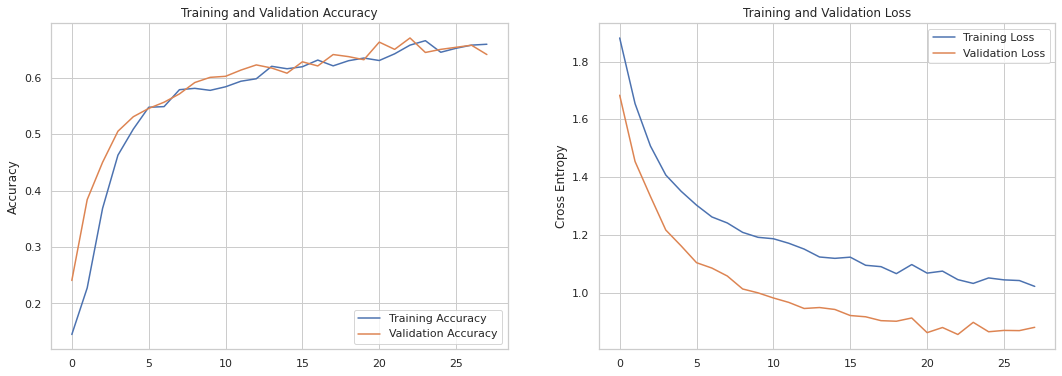

In [48]:
acc = history2.history['sparse_categorical_accuracy']
val_acc = history2.history['val_sparse_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score
predictions2 = model2.predict_generator(valid_generator)
predictions2 = np.argmax(predictions2, axis=-1)
true_labels = val['Labels'].astype(int)
score = accuracy_score(true_labels, predictions2)
print('Accuracy:',score)

Accuracy: 0.6709090909090909


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

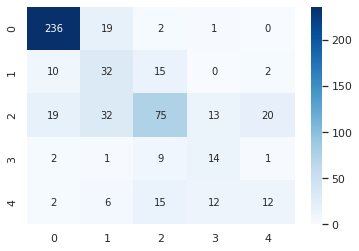

In [44]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions2)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')
from google.colab import files
plt.savefig("cnf_cw.png")
files.download("cnf_cw.png") 

In [43]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions2))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       258
           1       0.36      0.54      0.43        59
           2       0.65      0.47      0.55       159
           3       0.35      0.52      0.42        27
           4       0.34      0.26      0.29        47

    accuracy                           0.67       550
   macro avg       0.51      0.54      0.52       550
weighted avg       0.68      0.67      0.67       550



## Model 3 
Weighted loss + Fine tuning

In [24]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# base_model.summary()

In [25]:
# model3 = tf.keras.Sequential([
#   base_model(training = False),
#   keras.layers.GlobalAveragePooling2D(),
#   keras.layers.Dense(5, activation='softmax')
# ])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
model3 = keras.Model(inputs, outputs)

In [26]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True)])

model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
#set up callback
checkpoint_path = "Reg03/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
#train model
epochs = 30
steps_per_epoch = train_generator.n // batch_size
dev_steps = valid_generator.n // batch_size

history3 = model3.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_generator,
                              validation_steps=dev_steps, callbacks=[cp_callback, early_stop],
                              class_weight = class_weights
                              )

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 1.8846 - sparse_categorical_accuracy: 0.1371 - cohen_kappa: -5.9402e-04
Epoch 1: saving model to Reg03/cp.ckpt
80/80 [==============================] - 48s 428ms/step - loss: 1.8846 - sparse_categorical_accuracy: 0.1371 - cohen_kappa: -5.9402e-04 - val_loss: 1.6254 - val_sparse_categorical_accuracy: 0.2335 - val_cohen_kappa: 0.0446
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 1.5618 - sparse_categorical_accuracy: 0.3599 - cohen_kappa: 0.1588
Epoch 2: saving model to Reg03/cp.ckpt
80/80 [==============================] - 38s 459ms/step - loss: 1.5618 - sparse_categorical_accuracy: 0.3599 - cohen_kappa: 0.1588 - val_loss: 1.3824 - val_sparse_categorical_accuracy: 0.4062 - val_cohen_kappa: 0.1923
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 1.4275 - sparse_categorical_accuracy: 0.4828 - cohen_kappa: 0.2885
Epoch 3: saving model to Reg03/cp.ckpt
80/80 [=========================

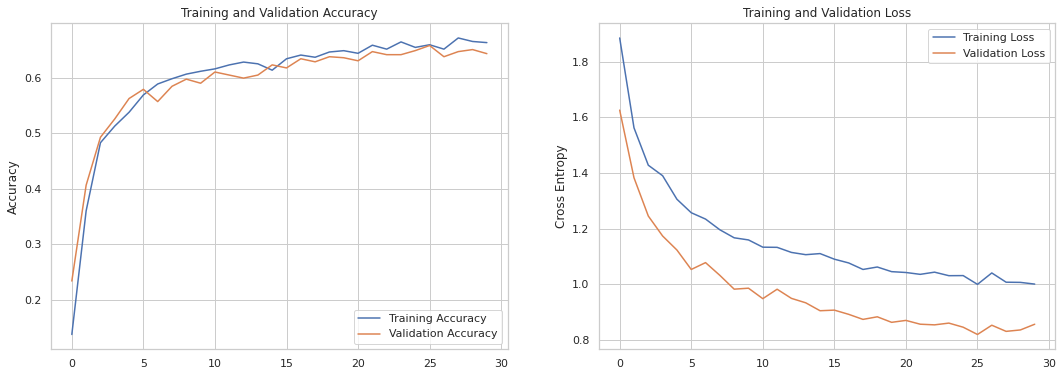

In [29]:
acc = []
val_acc = []
loss = []
val_loss = []
acc = history3.history['sparse_categorical_accuracy']
val_acc = history3.history['val_sparse_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score
predictions3 = model3.predict_generator(valid_generator)
predictions3 = np.argmax(predictions3, axis=-1)
true_labels = val['Labels'].astype(int)
score = accuracy_score(true_labels, predictions3)
print('Accuracy:',score)

Accuracy: 0.6454545454545455


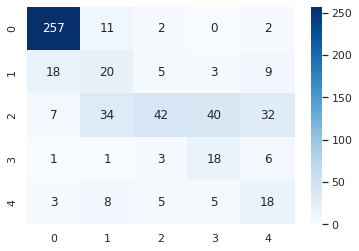

In [31]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions3)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')
# plt.savefig("cnf_cw.png")
# files.download("cnf_cw.png") 

In [32]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions3))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       272
           1       0.27      0.36      0.31        55
           2       0.74      0.27      0.40       155
           3       0.27      0.62      0.38        29
           4       0.27      0.46      0.34        39

    accuracy                           0.65       550
   macro avg       0.49      0.53      0.47       550
weighted avg       0.71      0.65      0.64       550



Unfreezing the base model

In [33]:
len(base_model.layers)

154

In [34]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False



In [35]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True)])

model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 1,867,845
Non-trainable params: 396,544
_________________________________________________________________


In [36]:
fine_tune_epochs = 20
total_epochs =  30 + fine_tune_epochs

history_fine = model3.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=total_epochs,
                              workers=4,
                              initial_epoch = history3.epoch[-1],
                              validation_data=valid_generator,
                              validation_steps=dev_steps, 
                              callbacks=[cp_callback, early_stop],
                              class_weight = class_weights
                              )

Epoch 30/50
79/80 [============================>.] - ETA: 0s - loss: 1.2465 - sparse_categorical_accuracy: 0.5798 - cohen_kappa: 0.4030
Epoch 30: saving model to Reg03/cp.ckpt
80/80 [==============================] - 43s 471ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.5796 - cohen_kappa: 0.4023 - val_loss: 1.0250 - val_sparse_categorical_accuracy: 0.5386 - val_cohen_kappa: 0.3638
Epoch 31/50
79/80 [============================>.] - ETA: 0s - loss: 1.1445 - sparse_categorical_accuracy: 0.6078 - cohen_kappa: 0.4473
Epoch 31: saving model to Reg03/cp.ckpt
80/80 [==============================] - 37s 453ms/step - loss: 1.1442 - sparse_categorical_accuracy: 0.6077 - cohen_kappa: 0.4474 - val_loss: 0.8734 - val_sparse_categorical_accuracy: 0.5827 - val_cohen_kappa: 0.3887
Epoch 32/50
80/80 [==============================] - ETA: 0s - loss: 1.0508 - sparse_categorical_accuracy: 0.6357 - cohen_kappa: 0.4837
Epoch 32: saving model to Reg03/cp.ckpt
80/80 [=============================

In [38]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

[0.1370999664068222,
 0.35993677377700806,
 0.48281311988830566,
 0.512840747833252,
 0.5377321243286133,
 0.5689451098442078,
 0.5887001156806946,
 0.5981825590133667,
 0.6064796447753906,
 0.6116159558296204,
 0.6159620881080627,
 0.6230738759040833,
 0.628210186958313,
 0.6250494122505188,
 0.6135914921760559,
 0.6341366767883301,
 0.6408534049987793,
 0.636902391910553,
 0.6463848352432251,
 0.6487554311752319,
 0.6440142393112183,
 0.6586329340934753,
 0.6515211462974548,
 0.6645594835281372,
 0.654681921005249,
 0.6594231724739075,
 0.6515211462974548,
 0.6716712713241577,
 0.6653496623039246,
 0.663281261920929,
 0.5796127915382385,
 0.607664942741394,
 0.6357170939445496,
 0.654681921005249,
 0.6586329340934753,
 0.6700908541679382,
 0.6847096085548401,
 0.7076254487037659,
 0.6894508004188538,
 0.7056499123573303,
 0.7190833687782288,
 0.7210588455200195,
 0.7321217060089111,
 0.7384433150291443,
 0.7392334938049316,
 0.7483208179473877,
 0.7554326057434082,
 0.747925698757171

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

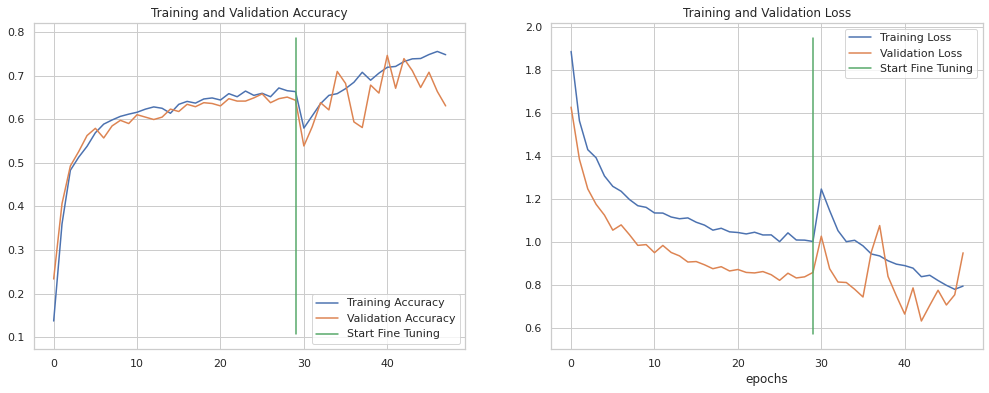

In [61]:
initial_epochs = 30
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')

plt.savefig("val_train_plot.png")
files.download("val_train_plot.png")
plt.show()

In [41]:
len(acc)
len(loss)

48

In [42]:
from sklearn.metrics import accuracy_score
predictions_fine = model3.predict_generator(valid_generator)
predictions_fine = np.argmax(predictions_fine, axis=-1)
true_labels = val['Labels'].astype(int)
score = accuracy_score(true_labels, predictions_fine)
print('Validation Accuracy:',score)

Validation Accuracy: 0.74


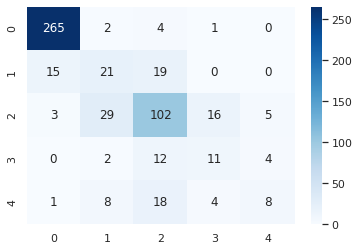

In [43]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions_fine)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')


In [44]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions_fine))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       272
           1       0.34      0.38      0.36        55
           2       0.66      0.66      0.66       155
           3       0.34      0.38      0.36        29
           4       0.47      0.21      0.29        39

    accuracy                           0.74       550
   macro avg       0.55      0.52      0.52       550
weighted avg       0.73      0.74      0.73       550



In [47]:
test_generator=dev_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))

Found 549 validated image filenames belonging to 5 classes.


In [53]:
from sklearn.metrics import accuracy_score
predictions_fine = model3.predict_generator(test_generator)
predictions_fine = np.argmax(predictions_fine, axis=-1)
true_labels = test['Labels'].astype(int)
score = accuracy_score(true_labels, predictions_fine)
print('Test Accuracy:',score)

Test Accuracy: 0.7632058287795993


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

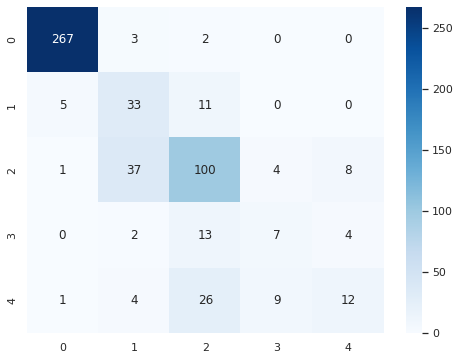

In [55]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions_fine)
plt.figure(figsize = (8,6))
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')
from google.colab import files
plt.savefig("cnf_test.png")
files.download("cnf_test.png") 


In [51]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions_fine))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       272
           1       0.42      0.67      0.52        49
           2       0.66      0.67      0.66       150
           3       0.35      0.27      0.30        26
           4       0.50      0.23      0.32        52

    accuracy                           0.76       549
   macro avg       0.58      0.56      0.56       549
weighted avg       0.76      0.76      0.76       549



In [52]:
from sklearn.metrics import accuracy_score
predictions_fine = model3.predict_generator(train_generator)
predictions_fine = np.argmax(predictions_fine, axis=-1)
true_labels = train['Labels'].astype(int)
score = accuracy_score(true_labels, predictions_fine)
print('Training Accuracy:',score)

Training Accuracy: 0.8056964494732735


Saving the model


In [63]:
files.download('final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 3 Resnet

In [109]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model2 = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model2.trainable = False
# base_model.summary()

234561536/234545216 [==============================] - 3s 0us/step


In [110]:
model4 = tf.keras.Sequential([
  base_model2,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(5, activation='softmax')
])

In [112]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', tfa.metrics.CohenKappa(num_classes = 5, sparse_labels=True)])

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58,341,893
Trainable params: 10,245
Non-trainable params: 58,331,648
_________________________________________________________________


In [113]:
from sklearn.utils import compute_class_weight 
train_classes = train_generator.classes
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.40489731437598736,
 1: 1.9416666666666667,
 2: 0.7343839541547278,
 3: 3.714492753623188,
 4: 2.6020304568527917}

In [114]:
#set up callback
checkpoint_path = "Reg04/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [115]:
valid_generator.batch_size

32

In [116]:
#train model
epochs = 30
steps_per_epoch = train_generator.n // batch_size
dev_steps = valid_generator.n // valid_generator.batch_size

history4 = model4.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_generator,
                              validation_steps=dev_steps, 
                              callbacks=[cp_callback, early_stop],
                              class_weight = class_weights
                              )

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 1.9439 - sparse_categorical_accuracy: 0.2588 - cohen_kappa: 0.0169
Epoch 1: saving model to Reg04/cp.ckpt
80/80 [==============================] - 55s 561ms/step - loss: 1.9439 - sparse_categorical_accuracy: 0.2588 - cohen_kappa: 0.0169 - val_loss: 1.5383 - val_sparse_categorical_accuracy: 0.3143 - val_cohen_kappa: 0.0976
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 1.6809 - sparse_categorical_accuracy: 0.3327 - cohen_kappa: 0.1105
Epoch 2: saving model to Reg04/cp.ckpt
80/80 [==============================] - 41s 499ms/step - loss: 1.6809 - sparse_categorical_accuracy: 0.3327 - cohen_kappa: 0.1105 - val_loss: 1.3859 - val_sparse_categorical_accuracy: 0.4136 - val_cohen_kappa: 0.2189
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 1.5594 - sparse_categorical_accuracy: 0.4097 - cohen_kappa: 0.2035
Epoch 3: saving model to Reg04/cp.ckpt
80/80 [==============================] - 4

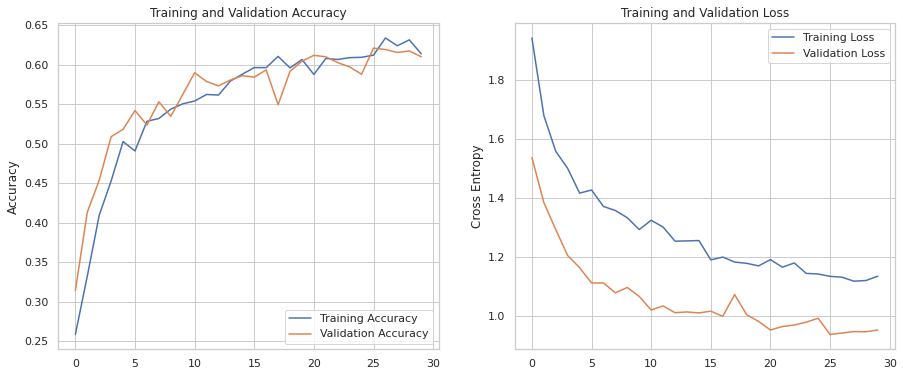

In [117]:
acc = history4.history['sparse_categorical_accuracy']
val_acc = history4.history['val_sparse_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [118]:
from sklearn.metrics import accuracy_score
predictions4 = model4.predict_generator(valid_generator)
predictions4 = np.argmax(predictions4, axis=-1)
true_labels = val['Labels'].astype(int)
score = accuracy_score(true_labels, predictions4)
print('Accuracy:',score)

Accuracy: 0.6127272727272727


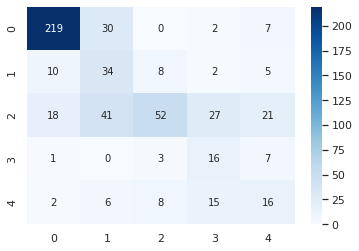

In [119]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions4)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')

In [120]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions4))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       258
           1       0.31      0.58      0.40        59
           2       0.73      0.33      0.45       159
           3       0.26      0.59      0.36        27
           4       0.29      0.34      0.31        47

    accuracy                           0.61       550
   macro avg       0.49      0.54      0.48       550
weighted avg       0.69      0.61      0.62       550



In [121]:
len(base_model2.layers)

564

## Fine tuning 

In [122]:
base_model2.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable = False

In [123]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy',tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True)])

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58,341,893
Trainable params: 56,404,741
Non-trainable params: 1,937,152
_________________________________________________________________


In [124]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine_model4 = model4.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=total_epochs,
                              workers=4,
                              initial_epoch = history4.epoch[-1],
                              validation_data=valid_generator,
                              validation_steps=dev_steps, 
                              callbacks=[cp_callback, early_stop],
                              class_weight = class_weights
                              )

Epoch 30/40
80/80 [==============================] - ETA: 0s - loss: 1.3329 - sparse_categorical_accuracy: 0.5820 - cohen_kappa: 0.3960
Epoch 30: saving model to Reg04/cp.ckpt
80/80 [==============================] - 66s 614ms/step - loss: 1.3329 - sparse_categorical_accuracy: 0.5820 - cohen_kappa: 0.3960 - val_loss: 0.9401 - val_sparse_categorical_accuracy: 0.5993 - val_cohen_kappa: 0.4275
Epoch 31/40
80/80 [==============================] - ETA: 0s - loss: 1.1933 - sparse_categorical_accuracy: 0.6199 - cohen_kappa: 0.4584
Epoch 31: saving model to Reg04/cp.ckpt
80/80 [==============================] - 47s 570ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.6199 - cohen_kappa: 0.4584 - val_loss: 0.9179 - val_sparse_categorical_accuracy: 0.6085 - val_cohen_kappa: 0.4434
Epoch 32/40
80/80 [==============================] - ETA: 0s - loss: 1.1077 - sparse_categorical_accuracy: 0.6432 - cohen_kappa: 0.4904
Epoch 32: saving model to Reg04/cp.ckpt
80/80 [=============================

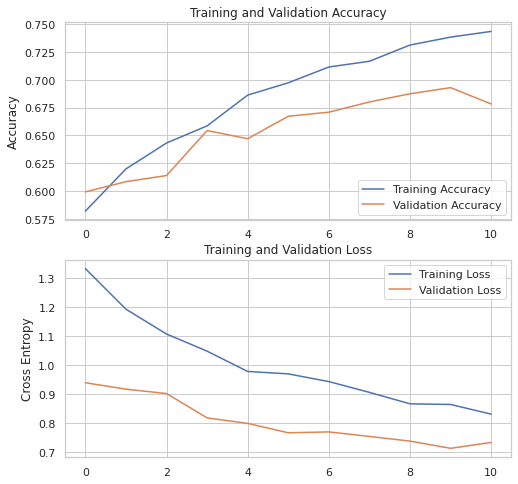

In [125]:
acc = history_fine_model4.history['sparse_categorical_accuracy']
val_acc = history_fine_model4.history['val_sparse_categorical_accuracy']

loss = history_fine_model4.history['loss']
val_loss = history_fine_model4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [126]:
from sklearn.metrics import accuracy_score
predictions_fine4 = model4.predict_generator(valid_generator)
predictions_fine4 = np.argmax(predictions_fine4, axis=-1)
true_labels = val['Labels'].astype(int)
score = accuracy_score(val['Labels'], predictions_fine4)
print('Validation Accuracy:',score)

Validation Accuracy: 0.68


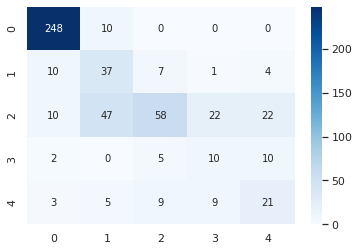

In [127]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions_fine4)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')

In [128]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions_fine4))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       258
           1       0.37      0.63      0.47        59
           2       0.73      0.36      0.49       159
           3       0.24      0.37      0.29        27
           4       0.37      0.45      0.40        47

    accuracy                           0.68       550
   macro avg       0.52      0.55      0.52       550
weighted avg       0.72      0.68      0.68       550



In [129]:
from sklearn.metrics import accuracy_score
predictions_fine4 = model4.predict_generator(test_generator)
predictions_fine4 = np.argmax(predictions_fine4, axis=-1)
true_labels = test['Labels'].astype(int)
score = accuracy_score(test['Labels'], predictions_fine4)
print('Test Accuracy:',score)

Test Accuracy: 0.6994535519125683


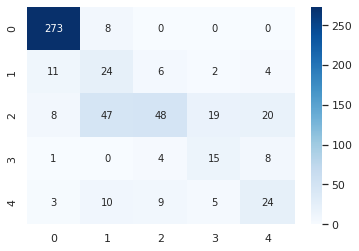

In [130]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(true_labels, predictions_fine4)
sns.heatmap(cnf_mat, annot=True, fmt='g', cmap='Blues')

In [131]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions_fine4))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       281
           1       0.27      0.51      0.35        47
           2       0.72      0.34      0.46       142
           3       0.37      0.54      0.43        28
           4       0.43      0.47      0.45        51

    accuracy                           0.70       549
   macro avg       0.54      0.57      0.53       549
weighted avg       0.74      0.70      0.70       549

